#  Visualisations

In [1]:
os.chdir('/Users/jamieelliott/Documents/Git/natural_spaces/DEFRA_natural_spaces-main')

In [85]:
%reload_ext autoreload
%autoreload 2

from model_config import *
from model_packages import *
from model_utils import *

In [3]:
# load shapefile with buffer zone geometries for each site 
accessibility= gpd.read_file('./data/accessibility.shp').to_crs(crs_deg)
accessibility['latitude']=accessibility['geometry'].centroid.y
accessibility['longitude']=accessibility['geometry'].centroid.x

In [4]:
#load data with UK regions 
regions= gpd.read_file('./data/NUTS_RG_20M_2021_4326.geojson')
# select desired geography level i.e. North East, North West etc
regions=regions.loc[(regions['CNTR_CODE']=='UK')&(regions['LEVL_CODE']==1)]
# create data frame with geometry of region related to each counter location
regions_geom=gpd.sjoin(left_df=accessibility, right_df=regions[['geometry', 'NUTS_NAME']], how='right')
regions_geom=regions_geom.drop(columns=['index_left'])

# spatially join counter locations to UK region but keep geometry of buffer zones
points_geom = gpd.sjoin(left_df=accessibility, right_df=regions[['geometry', 'NUTS_NAME']], how='left')
# Single data point (Canal Side) incorrectly assigned to Wales region, reassign point to North West 
points_geom.NUTS_NAME= np.where(points_geom.NUTS_NAME =='Wales', 'North West (England)', points_geom.NUTS_NAME)
points_geom=points_geom.drop(columns=['index_right'])

#  Final Blended Model Heatmaps

Visualisation of predictions from final model. Due to segmentation of data for cross validation predictions on training data set and validation data set are visualised together in order to visualise a complete temporal profile for each counter location.

In [5]:
# load data of final blended model prediction on train and validation set
pred_on_train= pd.read_pickle(data_folder+'pred_on_train_data.pkl')
pred_on_val= pd.read_pickle(data_folder+'pred_on_val_data.pkl')

In [7]:
# concatenate training and validation predictions
train_val_df= pd.concat([pred_on_train, pred_on_val], ignore_index=True, join='outer')

# create subset of points_geom with only sites in train and val, this is used for plotting later
train_sites= train_val_df.merge(points_geom, left_on='site', right_on='counter', how= 'inner')

# assign season to each data point
train_val_df['season']=train_val_df['Date'].apply(lambda x: x.split('-')[1]).\
apply(lambda x : get_season(x))

# create year column
train_val_df['year']= pd.to_datetime(train_val_df['Date']).dt.year
train_val_df= train_val_df.merge(accessibility,left_on=['site'],right_on='counter',how='outer')

# generate mean for each site per year and season
train_val_df= train_val_df.groupby(['site','year', 'season'], sort=False).mean().reset_index()

# add error column 
train_val_df['Error']= (train_val_df['people_counter_data']-train_val_df['prediction_label'])
train_val_df['Strava Error']= (train_val_df['people_counter_data']-train_val_df['total_trip_count'])

# wrangling for plotting purposes
train_val_df['year']= train_val_df['year'].astype(int)
train_val_df.season= train_val_df.season.astype('str').str.capitalize()
train_val_df= train_val_df.rename(columns={'total_trip_count':'Strava Trip Count', 'people_counter_data': 'People Counter Data', 'prediction_label': 'Predicted Count'})
# train_val_df= train_val_df.drop(columns=['Mean_dog_occupancy', 'waterside_length_km', 'land_type_labels_urban_and_rural_setings','habitat_type_labels_Grass_wood_bareground_coast',	'tourism_camp_site', 'tourism_guest_house', 'highway_bus_stop', 'tourism_attraction', 'amenity_pub', 'amenity_beer_garden', 'amenity_bus_station', 'amenity_food_court', 'amenity_shelter', 'Asian/Asian British', '2 or more cars or vans in household', 'Density (number of persons per sq_km)', 'tavg', 'area'])


# create df with regions
train_val_df_regions=train_val_df.merge(points_geom, how='inner', left_on='site', right_on='counter')
# group by region and sum
train_val_df_regions= train_val_df_regions.groupby(['NUTS_NAME', 'year', 'season']).mean().reset_index()
# merge again to regain geometry
train_val_df_regions= train_val_df_regions.merge(regions, how='inner', on='NUTS_NAME')
# convert to geodataframe
train_val_df_regions=gpd.GeoDataFrame(train_val_df_regions)

## Plotting for density maps

In [9]:
cols= ['People Counter Data', 'Predicted Count', 'Error', 'Strava Trip Count', 'Strava Error']

In [10]:
create_density_map(train_val_df, cols)

## Sites Coloured by region

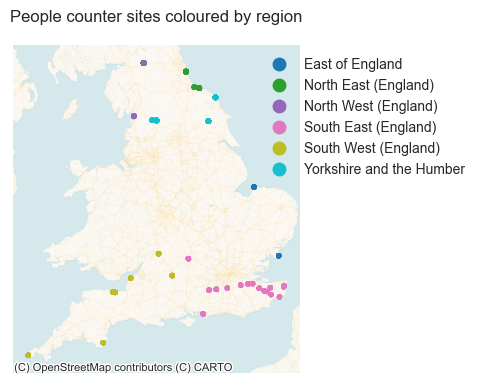

In [11]:
# create map of sites coloured by region

# convert to GeoDataFrame and change CRS
train_sites =gpd.GeoDataFrame(train_sites).to_crs('3857')

f, ax = plt.subplots(1, figsize=(5, 5))

train_sites.plot(
    # Colour by region label
    column='NUTS_NAME',
    # Consider label as categorical
    categorical=True,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker="o",
    # colours for markers
    cmap='tab10',
    # legend outside the map
    legend_kwds={"bbox_to_anchor": (1.62, 1)},
)

# Add basemap
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)


ax.set_title('People counter sites coloured by region')
ax.set_axis_off()
f.tight_layout()
# save figure to images folder
# pathlib.Path(f"./images/").mkdir(parents=True, exist_ok=True)
# f.savefig(f"./images/train_sites_regions.png", format= 'png', bbox_inches='tight')

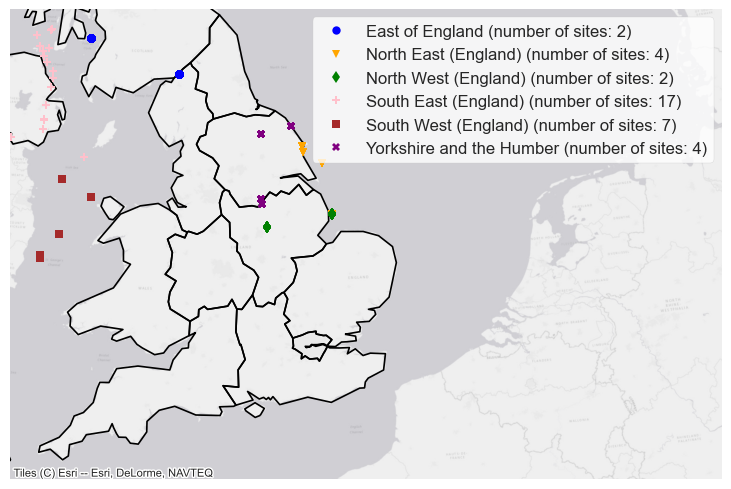

In [84]:
# Sites couloured by region blog visualisation

fig, ax = plt.subplots()

ax.set_aspect('equal')

regions.to_crs(crs_mtr).plot(ax=ax, facecolor= 'none', edgecolor='black', linewidth=1.2)

markers=[
 'o',
 'v',
 'd',
 "P",
 's',
 "X",
 '*',
 'h',
]
colours= {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

t= gpd.GeoDataFrame(train_sites).to_crs(crs_mtr)
t.geometry= t.geometry.centroid
margin = 490000
ax.set_xlim(t.bounds.minx.min()-40000, t.bounds.maxx.max() + margin)
ax.set_ylim(t.bounds.miny.min()-40000, t.bounds.maxy.max()+100000)
t=anonymise_coordinates(t, 5000)
groups=t[t['NUTS_NAME'] != 'London']
groups= groups.groupby('NUTS_NAME')

for (name, group), marker, colours in zip(groups, cycle(markers), cycle(colours)):
    ax.plot(group.longitude, group.latitude,marker=marker, color=colours,  label=(name+f' (number of sites: {group.site.unique().shape[0]})'), linestyle='', markersize=6)
    ax.legend(loc='upper right', fontsize=12, frameon=1, facecolor='white')#bbox_to_anchor=(2.55,1)
    ax.set_axis_off()




contextily.add_basemap(ax,crs= crs_mtr,source=contextily.providers.Esri.WorldGrayCanvas, zoom=8)
# Add padding between subplot titles and plot
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show();

# pathlib.Path(f"./outputs/").mkdir(parents=True, exist_ok=True)
# fig.savefig(f"./outputs/sites_x_region.png", format= 'png', dpi=300, bbox_inches='tight')

## Create Chloropleth visualisations

NameError: name 'lines' is not defined

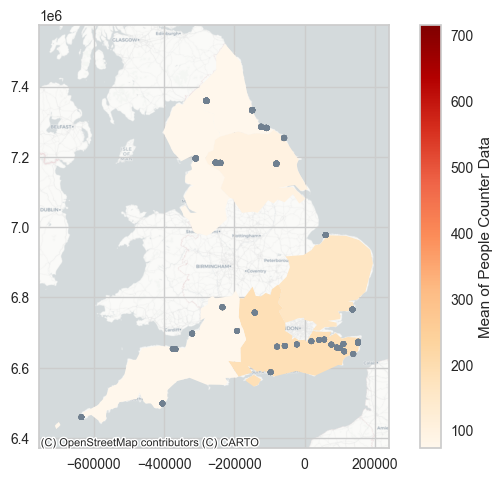

In [19]:
create_chlorpleth_map(train_val_df_regions, cols, False)

# Inference Visualisations

In [20]:
# load in data for estimations and prediction on unseen sites

# load CRT predictions
estimation_trained_model= pd.read_pickle('./data/estimation_trained_model.pkl')
estimation_trained_model= estimation_trained_model.rename(columns={'prediction_label':'Canals & Rivers Trust Prediction'})
# add season to each data point
estimation_trained_model['season']=estimation_trained_model['Date'].apply(lambda x: x.split('-')[1]).\
apply(lambda x : get_season(x))
# add year to each data point
estimation_trained_model['year']= pd.to_datetime(estimation_trained_model['Date']).dt.year

In [21]:
prediction_trained_model= pd.read_pickle(data_folder+'prediction_trained_model.pkl')

# add season to each data point
prediction_trained_model['season']=prediction_trained_model['Date'].apply(lambda x: x.split('-')[1]).\
apply(lambda x : get_season(x))

# add year to each data point
prediction_trained_model['year']= pd.to_datetime(prediction_trained_model['Date']).dt.year

# remove predcition label as we only want to visualise predcitions made on unsens sites 
# prediction_trained_model['prediction_label']= np.nan

In [22]:
models_df= pd.concat([prediction_trained_model,estimation_trained_model], ignore_index=True, join='outer' )
models_df= models_df.merge(accessibility,left_on=['site'],right_on='counter',how='outer')
models_df= models_df.merge(points_geom, how='inner', left_on='site', right_on='counter')

models_df= models_df.groupby(['NUTS_NAME','year', 'season']).mean().reset_index()
models_df=models_df.merge(regions[['NUTS_NAME','geometry']], how='inner', on='NUTS_NAME')
models_df['year']= models_df['year'].astype(int)
models_df.season= models_df.season.astype('str').str.capitalize()
modles_df= models_df.rename(columns={'total_trip_count':'Strava Trip Count', 'people_counter_data': 'People Counter Data', 'prediction_label': 'Predicted Count'}, inplace=True)
# # models_df.NUTS_NAME= np.where(models_df.NUTS_NAME =='Wales', 'North West (England)', models_df.NUTS_NAME)

models_df=gpd.GeoDataFrame(models_df)

NameError: name 'lines' is not defined

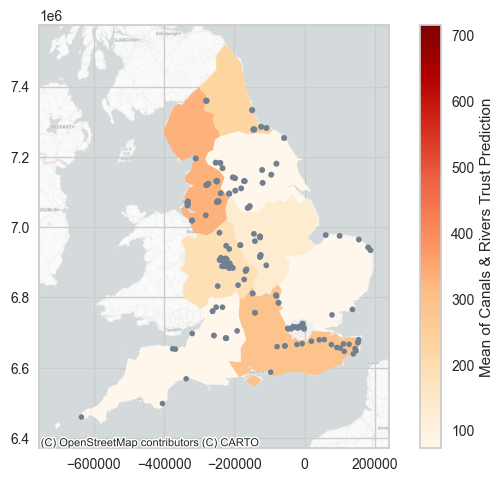

In [23]:
# create additional chloropleth maps for the estimation on unseen sites
create_chlorpleth_map(models_df, ['Canals & Rivers Trust Prediction'], True)

# Time Series

## Time series visualisation of training and validation data and predictions 

In [24]:
# concatenate data frames to have all predictions in one 
ts_df= pd.concat([pred_on_train, pred_on_val], ignore_index=True, join='outer')
# merge with points_geom to get regions
ts_df=ts_df.merge(points_geom, how='inner', left_on='site', right_on='counter')
# columns to keep
keepers= ['Date', 'people_counter_data', 'prediction_label', 'NUTS_NAME', 'site']

# copy data frame for plotting sites map
ts_df_geo=ts_df.copy()

# drop unneeded columns
ts_df= ts_df[ts_df.columns.intersection(keepers)]
ts_df.people_counter_data=ts_df.people_counter_data.astype('float32')


# get mean value from all sites in a region
ts_df= ts_df.groupby(['Date', 'NUTS_NAME']).mean().reset_index()
# get error between predicted and actual data for each region
ts_df['error']= (ts_df['people_counter_data']-ts_df['prediction_label'])
ts_df=ts_df.set_index(pd.to_datetime(ts_df.Date), drop=True)
ts_df=ts_df.drop('Date', axis=1)
ts_df.head()
# group by region
ts_df= ts_df.groupby('NUTS_NAME')

In [25]:
# create table figure for count of sites in each region
# group by region


site_region_count=ts_df_geo.groupby(['NUTS_NAME'])
# creat count column
site_region_count=pd.DataFrame(site_region_count['site'].nunique()).reset_index()
# rename for visualisation
site_region_count= site_region_count.rename(columns={'NUTS_NAME': 'Region', 'site':'Number of Sites'})

# create table
fig= ff .create_table(site_region_count)
fig.update_layout(autosize=False,
    width=350,
    height=200,)
fig.show()

# pathlib.Path(f"./images/").mkdir(parents=True, exist_ok=True)
# fig.write_image("./images/train_site_count_table.png", scale=2)

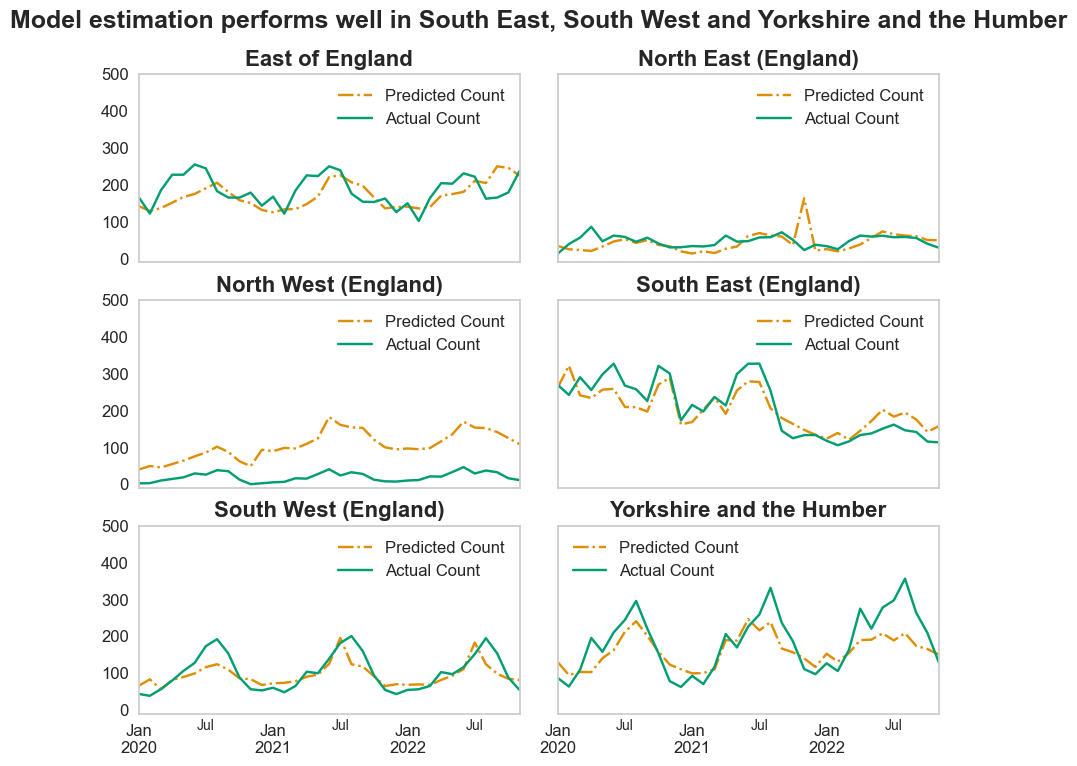

In [26]:
import pathlib 
# Define colorblind-friendly color palette
color_palette = sns.color_palette("colorblind")

# Define figure size and subplots layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,8), sharey=True, sharex=True)

# Set font size for all text elements
plt.rcParams.update({'font.size': 12})

# Loop through groups in dataframe
for (key, ax) in zip(ts_df.groups.keys(), axes.flatten()):
    # Set colorblind-friendly line style and color cycle
    cycler = plt.cycler(linestyle=['-.', '-', '--'], color=color_palette[1:4])
    ax.set_prop_cycle(cycler)
    # Plot predicted and actual people count data
    ts_df.get_group(key).plot(ax=ax, y=['prediction_label', 'people_counter_data'], grid=False, ylim=(-10, 500))
    # Set plot title and font size
    ax.set_title(key, fontsize=16, fontweight='bold')
    # Set y-axis ticks and font size
    ax.set_yticks([0, 100, 200, 300, 400, 500])
    ax.tick_params(axis='both', which='major', labelsize=12)
    # Set legend labels, title, and font size
    ax.legend(['Predicted Count', 'Actual Count'], fontsize=12)
    # Remove x-axis label
    ax.set_xlabel('')
    
# Add main plot title
fig.suptitle("Model estimation performs well in South East, South West and Yorkshire and the Humber", fontsize=18, fontweight='bold')
# Add padding between subplot titles and plot
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


# Make plot responsive for website viewing
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

pathlib.Path(f"./outputs/").mkdir(parents=True, exist_ok=True)
fig.savefig(f"./outputs/predict_vs_actual_ts_comparison.png", format= 'png', dpi=300, bbox_inches='tight')


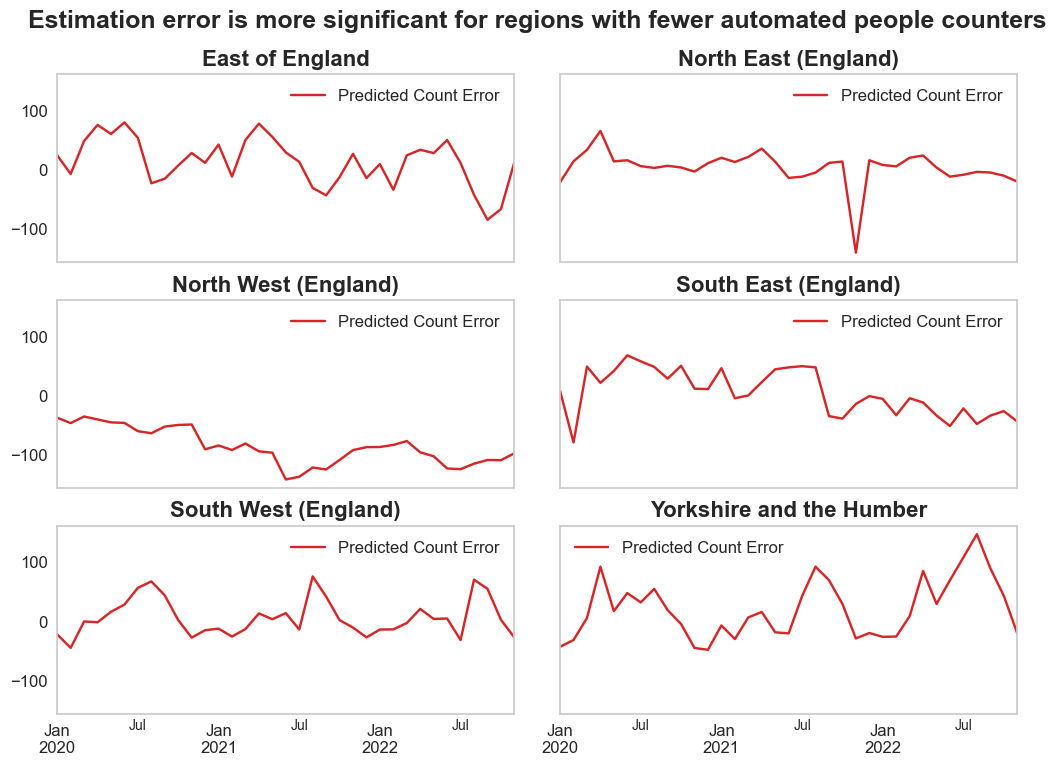

In [27]:
# create plot of time series for predicted and actual people count for each region
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), sharey=True, sharex=True)

# Set font size for all text elements
plt.rcParams.update({'font.size': 12})

# loop through groups in data frame
for (key, ax) in zip(ts_df.groups.keys(), axes.flatten()):
    cycler = plt.cycler(linestyle=['-', '-', '--'], color=['tab:red','tab:green', 'tab:red'])
    ax.set_prop_cycle(cycler)
    ts_df.get_group(key).plot(ax=ax, y= ['error'],grid=False) #ylim=(-10,500))
    ax.set_title(key, fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_ylabel('People Count')
    ax.legend(['Predicted Count Error'], fontsize=12)
    ax.set_xlabel('')


fig.suptitle("Estimation error is more significant for regions with fewer automated people counters", fontsize=18, fontweight='bold')
# Add padding between subplot titles and plot
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Make plot responsive for website viewing
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

pathlib.Path(f"./outputs/").mkdir(parents=True, exist_ok=True)
fig.savefig(f"./outputs/predict_vs_actual_error.png", format= 'png', dpi=300, bbox_inches='tight')

## Time series visualisation including estimation for unseen sites from Canals & Rivers Trust

In [68]:
similar_sites= pd.read_pickle(data_folder+'crt_and_similar_sites.pkl')

In [77]:
pred_on_val.loc[pred_on_val.site.isin(similar_sites.counter)].site.unique()

array(['Holme_Dunes_NNR', 'Nickle_Farm_Chartham', 'Hampton_Estate',
       'Clevedon', 'Crickley_Hill_Country_Park', 'Galley_Hall',
       'BoughtonAluph_Church', 'Ryhope_Dene', 'Bluebell_Hill',
       'Teesdale_Way'], dtype=object)

In [79]:
# concatenate data frames to have all predictions in one 
ts_df_crt= pd.concat([pred_on_train.loc[pred_on_train.site.isin(similar_sites.counter)], pred_on_val.loc[pred_on_val.site.isin(similar_sites.counter)], estimation_trained_model], ignore_index=True, join='outer')
# merge with points_geom to get regions
ts_df_crt=ts_df_crt.merge(points_geom, how='inner', left_on='site', right_on='counter')
# columns to keep
keepers= ['Date', 'people_counter_data', 'prediction_label', 'NUTS_NAME', 'Canals & Rivers Trust Prediction', 'site']

# copy data frame for plotting sites map
ts_df_crt_geo= ts_df_crt.copy()

# drop unneeded columns
ts_df_crt= ts_df_crt[ts_df_crt.columns.intersection(keepers)]
ts_df_crt.people_counter_data=ts_df_crt.people_counter_data.astype('float32')
cop=ts_df_crt.copy()
# get mean value from all sites in a region
ts_df_crt= ts_df_crt.groupby(['Date', 'NUTS_NAME']).mean().reset_index()
ts_df_crt=ts_df_crt.set_index(pd.to_datetime(ts_df_crt.Date), drop=True)
ts_df_crt=ts_df_crt.drop('Date', axis=1)

# group by region
ts_df_crt= ts_df_crt.groupby('NUTS_NAME')

In [64]:
cop.loc[(cop['NUTS_NAME']== 'North West (England)')].site.unique() #& (cop['Date']=='2020-04')]

array(['Galley_Hall', 'Walltown_Quarry', 'Anderton_Boat_Lift',
       'Canal_Side', 'Monk_Hall_Street', 'Tunnel_Street',
       'Healey_Wood_Close'], dtype=object)

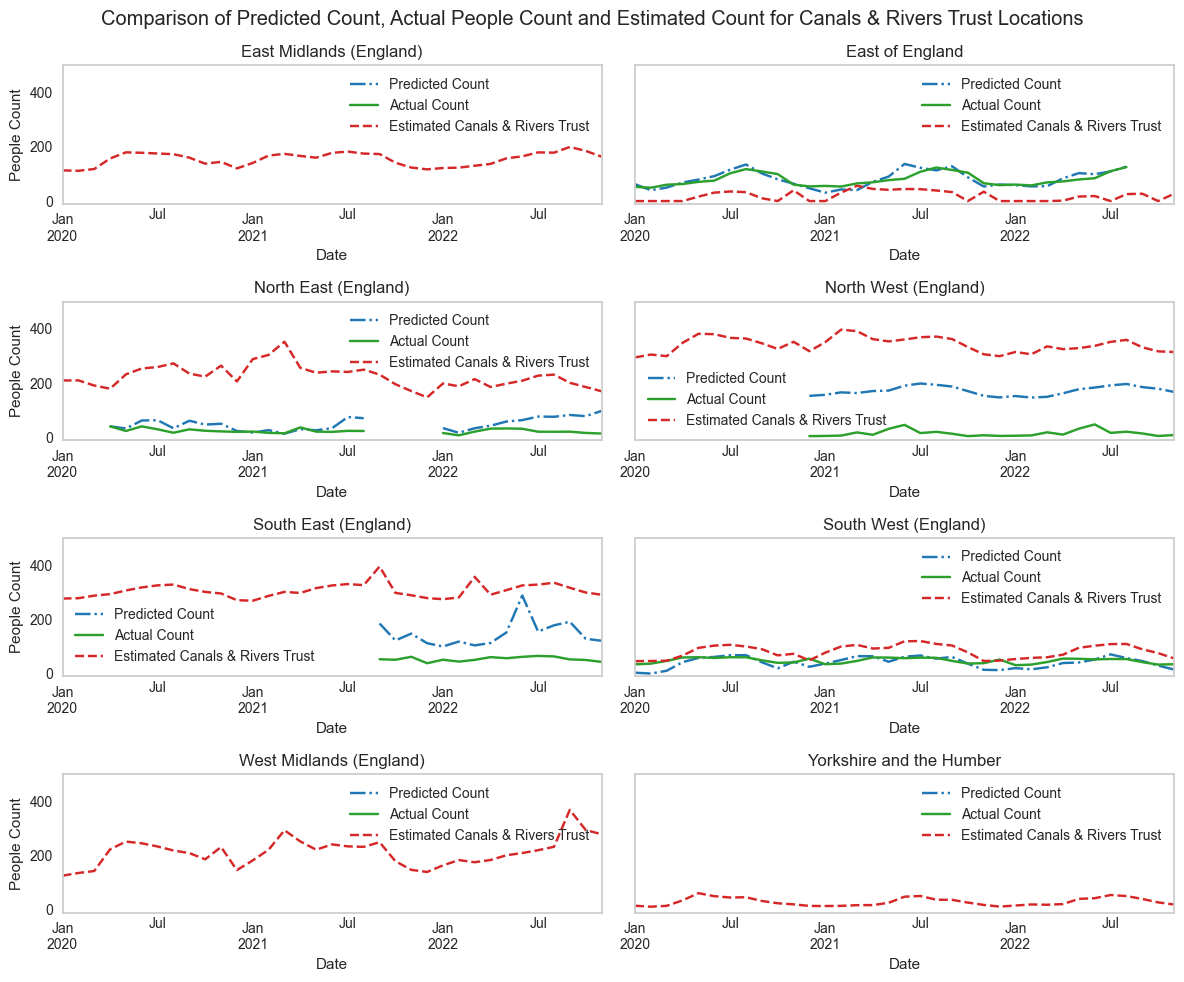

In [82]:
# create plot of time series for predicted and actual people count for each region including unseen data

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharey=True)

# loop through groups in data frame
for (key, ax) in zip(ts_df_crt.groups.keys(), axes.flatten()):
    cycler = plt.cycler(linestyle=['-.', '-', '--'], color=['tab:blue','tab:green', 'tab:red'])
    ax.set_prop_cycle(cycler)
    ts_df_crt.get_group(key).plot(ax=ax, grid=False, ylim=(-10,500))
    ax.set_title(key)
    ax.set_ylabel('People Count')
    ax.legend(['Predicted Count', 'Actual Count', 'Estimated Canals & Rivers Trust'])


fig.suptitle("Comparison of Predicted Count, Actual People Count and Estimated Count for Canals & Rivers Trust Locations")
fig.tight_layout()
# pathlib.Path(f"./outputs/").mkdir(parents=True, exist_ok=True)
fig.savefig(f"./outputs/similar_sites_predict_vs_actual_vs_CRT_ts_comparison.png", format= 'png')

## Visualisation of single counter location to show buffer zone

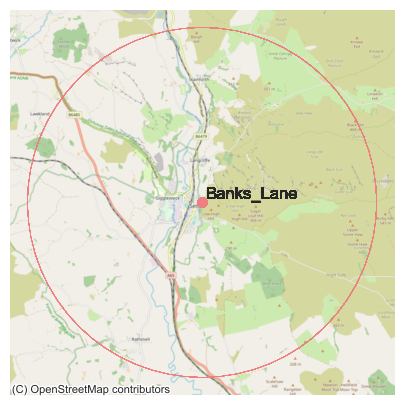

In [32]:
# convert to GeoDataFrame and change CRS
oneloc=ts_df_crt_geo.loc[ts_df_crt_geo['site']=='Banks_Lane']
oneloc=gpd.GeoDataFrame(oneloc).to_crs('3857')
oneloc['point']= oneloc.geometry.centroid

f, ax = plt.subplots(1, figsize=(5, 5))

oneloc.plot(
    # Colour by region label
    column='NUTS_NAME',
    # Consider label as categorical
    categorical=True,
    # Include legend
    legend=False,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker="o",
    markersize=1,
    # colours for markers
    facecolor='None',
    edgecolor='lightcoral',
    # Position legend outside the map
    legend_kwds={"bbox_to_anchor": (1.62, 1)},
    
)


# Add basemap
contextily.add_basemap(
    ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
)
oneloc.point.plot(ax=ax, facecolor='lightcoral')

for x, y ,label in zip(oneloc.point.x, oneloc.point.y, oneloc.site):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# Remove axes
ax.set_axis_off()

fig.show()
# f.savefig(f"./images/sites_regions_crt.png", formt= 'png')

 ## Visualisation of sites by region including Canals & Rivers Trust Sites

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'formt'

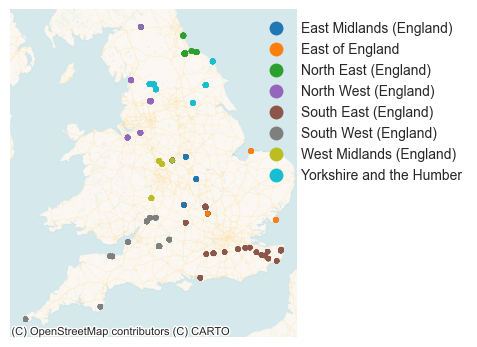

In [33]:
# create map of sites coloured by region

# convert to GeoDataFrame and change CRS
ts_df_crt_geo =gpd.GeoDataFrame(ts_df_crt_geo).to_crs('3857')

f, ax = plt.subplots(1, figsize=(5, 5))

ts_df_crt_geo.plot(
    # Colour by region label
    column='NUTS_NAME',
    # Consider label as categorical
    categorical=True,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker="o",
    # colours for markers
    cmap='tab10',
    # Position legend outside the map
    legend_kwds={"bbox_to_anchor": (1.62, 1)},
)

# Add basemap
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# ax.set_title('People counter sites coloured by region including Canals & Rivers Trust')
# Remove axes
ax.set_axis_off()
f.tight_layout()
# f.savefig(f"./images/sites_regions_crt.png", format= 'png')

 # Visualisation of sites most similar to Canals & Rivers Trust locations
 These are used for estimation  

In [ ]:
trng_sites= points_geom.loc[points_geom['counter'].isin(['Clevedon','Crickley_Hill_Country_Park',
'Galley_Hall','Rocket_Post_Field','Ryhope_Dene','Saltburn','Teesdale_Way','Bluebell_Hill',
'Hampton_Estate','Nickle_Farm_Chartham'])]

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 5))
# Plot individual locations

trng_sites.to_crs(crs_deg).plot(
    # Colour by cluster label
    column='NUTS_NAME',
    #color=trng_sites['Color'],
    cmap='tab10',
    # Consider label as categorical
    #categorical=False,
    # Add 50% of transparency
    alpha=0.95,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker="o",
    # Position legend outside the map
    legend_kwds={"bbox_to_anchor": (1.45, 1)},
)


# Add basemap
contextily.add_basemap(
    ax,
    crs=trng_sites.to_crs(crs_deg).crs.to_string(),
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
plt.title(label='Training Sites most similar to unseen locations')
ax.set_axis_off()
minx, miny, maxx, maxy = uk.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# f.tight_layout()

 # Visualisation of Canals & Rivers Trust sites with similar locations in the training data

In [ ]:
sites_estimation=points_geom.loc[points_geom['counter'].isin(sim_sites)]

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 5))
# Plot individual locations

sites_estimation.to_crs(crs_deg).plot(
    # Colour by cluster label
    column='NUTS_NAME',
    #color=trng_sites['Color'],
    cmap='tab10',
    # Consider label as categorical
    #categorical=False,
    # Add 50% of transparency
    alpha=0.95,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker="o",
    # Position legend outside the map
    legend_kwds={"bbox_to_anchor": (1.65, 1)},
)


# Add basemap
contextily.add_basemap(
    ax,
    crs=sites_estimation.to_crs(crs_deg).crs.to_string(),
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
plt.title(label='Most Similar sites in unseen data')
    
ax.set_axis_off()
f.tight_layout()

In [ ]:
trng_estimation= pd.concat([sites_estimation, trng_sites])

d= {'Number of Sites': trng_estimation.groupby(['NUTS_NAME']).counter.nunique()}
trng_estimation= pd.DataFrame(d)
trng_estimation= trng_estimation.reset_index()

# create table
fig= ff.create_table(trng_estimation)
fig.update_layout(autosize=False,
    width=350,
    height=200,)
fig.show()
fig.write_image("./outputs/site_count_crt_table.png", scale=2)

# POIs Visualisations

In [ ]:
df_demg=pd.read_pickle(census_locn_file)
# Area of each buffer region around the counter sites.
# Buffer zone is 5km radius around each site:pi*r^2: 78.5 sq km
area_sites_oa=df_demg.groupby('counter')['area_sq_km'].sum().reset_index()

In [ ]:
# Read the data saved locally
ne_pois_df=pd.read_pickle(data_folder+'ne_pois_df.pkl')

# Read the data saved locally
nd_pois_df=pd.read_pickle(data_folder+'dw_pois_df.pkl')

# Read the data saved locally: river and canal trust
cr_pois_df=pd.read_pickle(data_folder+'rvr_cnl_pois_df.pkl')


# All pois across all sites
df_pois_all_sites=pd.concat([ne_pois_df,nd_pois_df,cr_pois_df]).dropna(axis=1).reset_index(drop=True)

# Merge it with buffer zone areas for each site
df_pois_all_sites=df_pois_all_sites.merge(area_sites_oa.rename(columns={'counter':'site'}),on=['site'],how='outer')
# create data frame of raw POI numbers 
raw_df= df_pois_all_sites.copy()

num_cols=[x for x in df_pois_all_sites.columns if x not in ['area_sq_km','site']]

# Density of pois--CJ: Is this better than raw numbers ?
# Create data frame containing density of POIs by buffer zone area
df_pois_all_sites[num_cols]=df_pois_all_sites[num_cols].div(df_pois_all_sites['area_sq_km'],axis=0)

# del df_pois_all_sites['area_sq_km']

In [ ]:
# create sum of all POIs for each site
raw_df['All POIs']= raw_df.iloc[:, 0:17].sum(axis=1)
# crreate sum of all POIs excluding pubs
raw_df['POIs Excluding Pubs']= raw_df.drop('amenity_pub', axis=1).iloc[:, 0:16].sum(axis=1)
# add urban_rural
ur= pd.read_pickle(data_folder+'complete_dataset.pkl')
raw_df=raw_df.merge(ur[['site', 'land_type_labels']], on='site', how='inner')


# merge to get spatial information
raw_df= raw_df.merge(accessibility, left_on='site', right_on='counter', how='inner')
raw_df= raw_df.rename(columns={'tourism_attraction': 'Tourist Attractions', 'amenity_pub': 'Pubs', 'amenity_beer_garden': 'Beer Gardens','amenity_bus_station': 'Bus Stations', 'amenity_food_court': 'Food Courts','amenity_shelter':'Shelters'})

### Box Plots of raw POI numbers for each region

In [ ]:
# creat data frame not containing sites from London. This helps with visualisations as London has a disporportionately high number of POIs
# raw_df= raw_df.merge(accessibility, left_on='site', right_on='counter', how='inner')
not_ldn= gpd.sjoin(left_df=gpd.GeoDataFrame(raw_df).to_crs(crs_mtr), right_df=regions_geom.to_crs(crs_mtr), how='right')

ldn=['London']
not_ldn= not_ldn[~not_ldn.NUTS_NAME.isin(ldn)]

for i in ['All POIs', 'POIs Excluding Pubs', 'Pubs']:
    regions = not_ldn.NUTS_NAME.unique()
    colors = sns.color_palette('hls', len(regions))
    palette = {region: color for region, color in zip(regions, colors)}
    
    fig, ax= plt.subplots(1,1)
    sns.boxplot(ax= ax, x=i, y='NUTS_NAME', data= not_ldn.sort_values('NUTS_NAME'), palette=palette)
    fig.suptitle(f'Boxplot of {i} for each UK region')
    fig.tight_layout()
    fig.show()
    # pathlib.Path(f"./images/POIs/").mkdir(parents=True, exist_ok=True)
    # fig.savefig(f'./images/POIs/boxplot_{i}.png')
      

### Box Plots of POI Density numbers for each region

In [ ]:
df_pois_all_sites=df_pois_all_sites.merge(accessibility, left_on='site', right_on='counter', how='inner')
not_ldn_density= gpd.sjoin(left_df=gpd.GeoDataFrame(df_pois_all_sites).to_crs(crs_mtr), right_df=regions_geom.to_crs(crs_mtr), how='left')
ldn=['London']
not_ldn_density= not_ldn_density[~not_ldn_density.NUTS_NAME.isin(ldn)]



# not_ldn_density=not_ldn_density.merge(ur[['site', 'land_type_labels']], on='site', how='inner')
# not_ldn_density=not_ldn_density.groupby('land_type_labels').mean().reset_index()


# create sum of all POIs for each site
not_ldn_density['All POIs']= not_ldn_density.iloc[:, 0:17].sum(axis=1)
# crreate sum of all POIs excluding pubs
not_ldn_density['POIs Excluding Pubs']= not_ldn_density.drop('amenity_pub', axis=1).iloc[:, 0:16].sum(axis=1)

# df_pois_all_sites=df_pois_all_sites.merge(ur[['site', 'land_type_labels']], on='site', how='inner')
# df_pois_all_sites=df_pois_all_sites.merge(accessibility, left_on='site', right_on='counter', how='inner')

# not_ldn_density= gpd.GeoDataFrame(not_ldn_density)

In [ ]:
sns.violinplot(x='All POIs', y='land_type_labels', data= not_ldn.sort_values('All POIs'))

In [ ]:
sns.violinplot(x='POIs Excluding Pubs', y='land_type_labels', data= not_ldn.sort_values('POIs Excluding Pubs'))

In [ ]:
sns.violinplot(x='Pubs', y='land_type_labels', data= not_ldn.sort_values('Pubs'))

# Chloropleth Maps

## Raw POI numbers

In [ ]:
# create dataframe where raw POI numbers are totalled per region then divided by the total area of buffer zones within that region

poi_bz= not_ldn.groupby('NUTS_NAME').sum().reset_index()
poi_bz['NUTS_NAME']= np.where(poi_bz.NUTS_NAME =='Wales', 'North West (England)', poi_bz.NUTS_NAME) 
poi_bz['All POIs']= poi_bz['All POIs']/poi_bz['area_left']
poi_bz['POIs Excluding Pubs']= poi_bz['POIs Excluding Pubs']/poi_bz['area_left']
poi_bz['Pubs']= poi_bz['Pubs']/poi_bz['area_left']
poi_bz= poi_bz.merge(regions_geom[['geometry', 'NUTS_NAME' ]], on= 'NUTS_NAME', how='inner')

poi_bz=gpd.GeoDataFrame(poi_bz)

In [ ]:
# plot All POIs


cols= ['All POIs', 'POIs Excluding Pubs', 'Pubs']

for col in cols:
    fig, ax = plt.subplots(1, 1)
    data=poi_bz.to_crs('3857').plot(column=col, ax=ax, legend=True,cmap='OrRd',
        legend_kwds={'label':f'{col}','orientation':'vertical'}
    )

    ts_df_crt_geo =gpd.GeoDataFrame(ts_df_crt_geo).to_crs('3857')

    points=ts_df_crt_geo.plot(
        # Colour by region label
        column='NUTS_NAME',
        # Consider label as categorical
        categorical=True,
        legend=True,
        label='People Counters',
        # Draw on axis `ax`
        ax=ax,
        # Use circle as marker
        marker="o",
        # marker size
        markersize=1,
        # colours for markers
        color='slategrey',
    )

    # Add basemap
    contextily.add_basemap(
        ax,
            source=contextily.providers.CartoDB.Positron,
    )

    # add second legend for peopl counter locations
    legend1 = ax.legend(handles=[
                lines.Line2D(
                    [],
                    [],
                    color="slategrey",
                    lw=0,
                    marker="o",
                    markersize=5,
                    label='People Counters',
                    )], 
            scatterpoints=1, frameon=True,
            labelspacing=1, loc='upper right', fontsize=8,  
            title_fontsize=10,
            labelcolor='black',
            markerfirst=True,
            labels=['People Counters']
            )
    fig.gca().add_artist(legend1)

    ax.set_axis_off()

    ax.set_title(f'{col} per area of all buffer zones in each region')

    fig.show()
    fig.tight_layout()
    # fig.savefig(f'./images/POIs/total_buffer_area_{col}.png')

## POI density

In [ ]:
# create dataframe where POI densities are totalled per region then divided by the total area of buffer zones within that region

poi_bz_density= not_ldn_density.groupby('NUTS_NAME').sum().reset_index()
poi_bz_density['NUTS_NAME']= np.where(poi_bz_density.NUTS_NAME =='Wales', 'North West (England)', poi_bz_density.NUTS_NAME) 
poi_bz_density['All POIs']= poi_bz_density['All POIs']/poi_bz_density['area_left']
poi_bz_density['POIs Excluding Pubs']= poi_bz_density['POIs Excluding Pubs']/poi_bz_density['area_left']
poi_bz_density['amenity_pub']= poi_bz_density['amenity_pub']/poi_bz_density['area_left']
poi_bz_density= poi_bz_density.merge(regions_geom[['geometry', 'NUTS_NAME' ]], on= 'NUTS_NAME', how='inner')

poi_bz_density=gpd.GeoDataFrame(poi_bz_density)

In [ ]:
# plot All POIs


cols= ['All POIs', 'POIs Excluding Pubs', 'amenity_pub']

for col in cols:
    fig, ax = plt.subplots(1, 1)
    data=poi_bz_density.to_crs('3857').plot(column=col, ax=ax, legend=True,cmap='OrRd',
        legend_kwds={'label':f'Mean of {col}/km2 in Region','orientation':'vertical'}
    )

    ts_df_crt_geo =gpd.GeoDataFrame(ts_df_crt_geo).to_crs('3857')

    points=ts_df_crt_geo.plot(
        # Colour by region label
        column='NUTS_NAME',
        # Consider label as categorical
        categorical=True,
        legend=True,
        label='People Counters',
        # Draw on axis `ax`
        ax=ax,
        # Use circle as marker
        marker="o",
        # marker size
        markersize=1,
        # colours for markers
        color='slategrey',
    )

    # Add basemap
    contextily.add_basemap(
        ax,
            source=contextily.providers.CartoDB.Positron,
    )

    # add second legend for peopl counter locations
    legend1 = ax.legend(handles=[
                lines.Line2D(
                    [],
                    [],
                    color="slategrey",
                    lw=0,
                    marker="o",
                    markersize=5,
                    label='People Counters',
                    )], 
            scatterpoints=1, frameon=True,
            labelspacing=1, loc='upper right', fontsize=8,  
            title_fontsize=10,
            labelcolor='black',
            markerfirst=True,
            labels=['People Counters']
            )
    fig.gca().add_artist(legend1)

    ax.set_axis_off()

    ax.set_title(f'Mean of {col}/km2 by region')

    fig.show()
    fig.savefig(f'./images/POIs/pois_chloropleth_density_{col}.png')

## POIs visualisations for training data sites (i.e. not Canals & Rivers Trust locations)

In [ ]:
ur= pd.read_pickle(data_folder+'complete_dataset.pkl')

# create not crt data
not_crt=pd.concat([ne_pois_df,nd_pois_df]).dropna(axis=1).reset_index(drop=True)
not_crt=not_crt.merge(area_sites_oa.rename(columns={'counter':'site'}),on=['site'],how='inner')

# RAW
raw_not_crt= not_crt.copy()
raw_not_crt=raw_not_crt.merge(accessibility, left_on='site', right_on='counter', how='inner')

# creat data frame not containing sites from London. This helps with visualisations as London has a disporportionately high number of POIs
not_ldn_not_crt= gpd.sjoin(left_df=gpd.GeoDataFrame(raw_not_crt).to_crs(crs_mtr), right_df=points_geom.to_crs(crs_mtr), how='left')
ldn=['London']
not_ldn_not_crt= not_ldn_not_crt[~not_ldn_not_crt.NUTS_NAME.isin(ldn)]
not_ldn_not_crt=not_ldn_not_crt.merge(ur[['site', 'land_type_labels']], on='site', how='inner')

# create sum of all POIs for each site
not_ldn_not_crt['All POIs']= not_ldn_not_crt.iloc[:, 0:17].sum(axis=1)
# crreate sum of all POIs excluding pubs
not_ldn_not_crt['POIs Excluding Pubs']= not_ldn_not_crt.drop('amenity_pub', axis=1).iloc[:, 0:16].sum(axis=1)


# DENSITY
num_cols=[x for x in not_crt.columns if x not in ['area_sq_km','site']]


# Density of pois--CJ: Is this better than raw numbers ?
not_crt[num_cols]=not_crt[num_cols].div(not_crt['area_sq_km'],axis=0)

not_crt=not_crt.merge(accessibility, left_on='site', right_on='counter', how='inner')
not_ldn_not_crt_density= gpd.sjoin(left_df=gpd.GeoDataFrame(not_crt).to_crs(crs_mtr), right_df=points_geom.to_crs(crs_mtr), how='left')
ldn=['London']
not_ldn_not_crt_density= not_ldn_not_crt_density[~not_ldn_not_crt_density.NUTS_NAME.isin(ldn)]



not_ldn_not_crt_density=not_ldn_not_crt_density.merge(ur[['site', 'land_type_labels']], on='site', how='inner')
# not_ldn_not_crt_density=not_ldn_not_crt_density.groupby('land_type_labels').mean().reset_index()


# create sum of all POIs for each site
not_ldn_not_crt_density['All POIs']= not_ldn_not_crt_density.iloc[:, 0:17].sum(axis=1)
# crreate sum of all POIs excluding pubs
not_ldn_not_crt_density['POIs Excluding Pubs']= not_ldn_not_crt_density.drop('amenity_pub', axis=1).iloc[:, 0:16].sum(axis=1)

### Visualisation by land type label

In [ ]:
sns.violinplot(x='All POIs', y='land_type_labels', data= not_ldn_not_crt.sort_values('All POIs'))

In [ ]:
sns.violinplot(x='All POIs', y='land_type_labels', data= not_ldn_not_crt_density.sort_values('All POIs'))

In [ ]:
sns.violinplot(x='POIs Excluding Pubs', y='land_type_labels', data= not_ldn_not_crt.sort_values('POIs Excluding Pubs'))

In [ ]:
sns.violinplot(x='POIs Excluding Pubs', y='land_type_labels', data= not_ldn_not_crt_density.sort_values('POIs Excluding Pubs'))

In [ ]:
sns.violinplot(x='amenity_pub', y='land_type_labels', data= not_ldn_not_crt.sort_values('amenity_pub'))

In [ ]:
sns.violinplot(x='amenity_pub', y='land_type_labels', data= not_ldn_not_crt_density.sort_values('amenity_pub'))